In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 5
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [3]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################
#   DEFINING THE TOP 2D FOURIER LAYER

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [20]:
# MODELS
####################################### MODELS ###############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



################################ 1 FOURIER LAYER NETWORK ARCHITECTURE ###########################################

class FNO2d_1L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_1L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



############################ 2 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_2L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_2L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        #self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        #self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        #self.w2 = nn.Conv2d(self.width, self.width, 1)
        #self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)






############################ 4 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_4L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_4L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


############################ 6 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_6L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_6L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)



        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)





############################ 8 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_8L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_8L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv6 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv7 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)
        self.w7 = nn.Conv2d(self.width, self.width, 1)



        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv6(x)
        x2 = self.w6(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv7(x)
        x2 = self.w7(x)
        x = x1 + x2
        
        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [5]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/10k_real_dataset')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print(X_train.shape, y_train.shape)

torch.Size([8000, 8, 8, 1]) torch.Size([8000, 16, 16, 1])


In [6]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [7]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 
# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

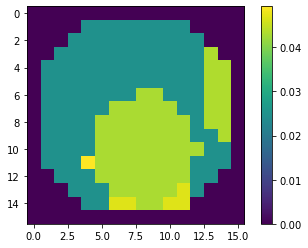

In [8]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

1664132
0 15.778823100030422 0.16038231813907625 0.1178160474896431
1 11.918571799993515 0.11722089995443821 0.11099148917198182
2 11.87934929993935 0.11030273996293545 0.1099895547926426
3 11.668465499999002 0.10576386893540621 0.10982627540826798
4 11.881511899991892 0.10506339667737484 0.10126307472586632
5 11.909641499980353 0.10136061401665211 0.09699635115265846
6 12.361726299975999 0.09909122120589017 0.09746725341677666
7 11.839472600026056 0.09693719031661749 0.09419297191500664
8 11.968980899895541 0.09550126920640468 0.09403715750575066
9 11.880381199996918 0.09278836233913898 0.09442267188429833
10 11.943030399968848 0.09157198558747769 0.08911058244109153
11 11.92792519996874 0.08957839392125606 0.09207874244451522
12 12.691127400030382 0.08832280821353197 0.08647756305336952
13 11.987587500014342 0.08676323526352644 0.08742640990018845
14 12.004790000035428 0.08592151791602373 0.08654781568050385
15 12.010600499925204 0.08414055518060923 0.08376656353473663
16 12.08341289

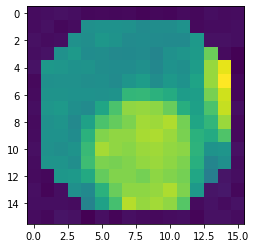

In [9]:
# ONE LAYER RESULTS
############################################################################

model_1L = FNO2d(modes, modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno2D_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

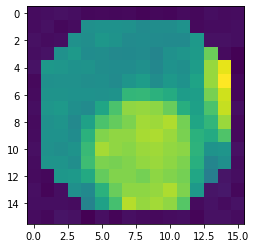

In [10]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)

422724
0 5.005744399968535 2.067723028600216 0.6878974881172181
1 4.703218099894002 0.5106693753302097 0.3356432716846466
2 4.739129199995659 0.32728948602080343 0.3531242672204971
3 4.712262300075963 0.26377962593734267 0.2486000412106514
4 5.077905000071041 0.2522142539024353 0.23865583115816116
5 4.9268125999951735 0.24238622371852397 0.2366520054936409
6 4.908343099988997 0.36171659457683564 0.8334909756183624
7 5.085611999966204 0.2885590569227934 0.24972486209869385
8 4.8940969000104815 0.24390580201148987 0.24459325098991394
9 5.121048600063659 0.23138192975521088 0.23289519172906875
10 4.690891099977307 0.2262935496121645 0.22130060243606567
11 4.462268600007519 0.21938364149630069 0.21953573101758958
12 4.48292879993096 0.21658472068607806 0.2066345419883728
13 4.45986029994674 0.21302167777717113 0.2075312957763672
14 4.457008600002155 0.2083724732398987 0.20001100766658783
15 4.420207499992102 0.20600614120066166 0.2035417086482048
16 4.493276500026695 0.2023373096883297 0.1

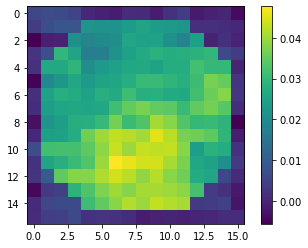

In [19]:
# ONE LAYER RESULTS
############################################################################

model_1L = FNO2d_1L(modes, modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno2D_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

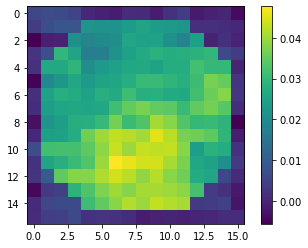

In [26]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_1lv2.png'
plt.savefig('./images/' + save_recon)

In [ ]:
# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

836484
0 7.141834900015965 0.42256637385487555 0.19488429695367812
1 6.990076299989596 0.16884796153008938 0.15128537636995315
2 6.908984599984251 0.1558324271440506 0.171465447306633
3 6.588973799953237 0.14567889449745416 0.1447165310382843
4 6.564982699928805 0.13851879741996526 0.13354485803842545
5 6.991382900043391 0.1319749773219228 0.12156500312685967
6 7.01495199999772 0.1290064985603094 0.12479944890737533
7 7.254868599935435 0.12538483606278897 0.1196617086827755
8 6.913460700074211 0.1232480472549796 0.1216067577302456
9 6.920857799937949 0.12207339201122522 0.11451838898658752
10 7.446004300029017 0.11998881682753564 0.12443550828099251
11 6.851698400103487 0.11914094388484955 0.11475301212072372
12 6.932945900014602 0.11754936887323857 0.12110403829813003
13 7.087445199955255 0.11560967921465636 0.11552983498573303
14 6.7857817999320105 0.11489671593159437 0.11255586650967599
15 6.9037842999678105 0.11309167228639126 0.11196553403139115
16 6.980031400104053 0.112271925732

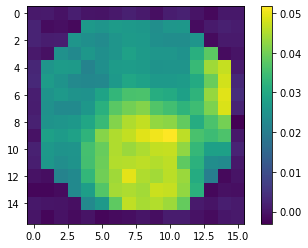

In [21]:
# TWO LAYER RESULTS
############################################################################

model_2L = FNO2d_2L(modes, modes, width).cuda()
print(count_params(model_2L))
output_2L = train_model(model_2L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_2L_model = output_2L.get("model")
torch.save(output_2L_model, 'fno2d_2l.h5')


results_2L = model_metrics(output_2L_model,test_loader,ntrain)

# TWO LAYER RESULTS
############################################################################
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

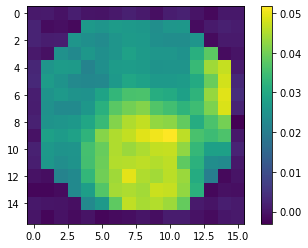

In [29]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_2lv2.png'
plt.savefig('./images/' + save_recon)

1664004
0 11.309421300073154 0.2002257088571787 0.14734102952480316
1 10.792567700031213 0.12636020001769066 0.12365811336040497
2 11.036727600032464 0.11546137902885675 0.10873916533589363
3 10.864561300026253 0.10894458112865686 0.11734052443504334
4 10.894826299976557 0.10462580928206444 0.12137091916799546
5 10.795651899999939 0.10360214952379465 0.10013678765296936
6 11.014472999959253 0.09946882100403309 0.09621623760461807
7 11.13466119999066 0.09853911431133747 0.1010513559281826
8 10.669030799996108 0.09658654318004846 0.09648101878166199
9 10.664278000011109 0.09504840384423732 0.09324809762835502
10 10.52470790001098 0.09353347913175822 0.09732904157042503
11 10.741318300017156 0.09134833167493343 0.10316959619522095
12 10.436344100045972 0.09072769071906805 0.09453065985441209
13 10.348832000046968 0.08975541651248932 0.09007075548171997
14 10.110861700028181 0.08811451552063226 0.08843406653404236
15 10.333875499898568 0.0870195537135005 0.09283193388581276
16 10.371555300

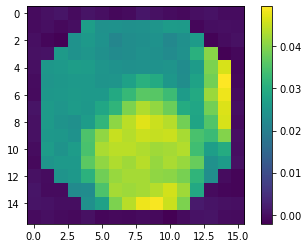

In [22]:
# FOUR LAYER RESULTS
############################################################################

model_4L = FNO2d_4L(modes, modes, width).cuda()
print(count_params(model_4L))
output_4L = train_model(model_4L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_4L_model = output_4L.get("model")
torch.save(output_4L_model, 'fno2d_4l.h5')


results_4L = model_metrics(output_4L_model,test_loader,ntrain)

# FOUR LAYER RESULTS
############################################################################
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

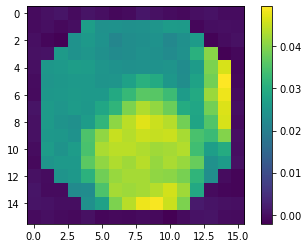

In [31]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_4lv2.png'
plt.savefig('./images/' + save_recon)

2491524
0 14.87088830000721 0.19137074983865024 0.12793705758452414
1 15.574207699974068 0.11786281887441874 0.11578672501444817
2 14.978639399982058 0.11038288802653551 0.10327227556705475
3 15.309618100058287 0.10448137789219618 0.09998197436332702
4 15.149742000037804 0.10137588246911765 0.0979411401450634
5 15.004409999935888 0.09714830461889505 0.09560677191615105
6 15.304969800054096 0.09458006894588471 0.09724472719430924
7 15.583600500016473 0.09242247483879328 0.0901684876382351
8 15.555071400012821 0.08921614076942205 0.09078393828868866
9 15.170897600008175 0.08658405292034149 0.08548553025722504
10 14.989378799917176 0.084892521828413 0.08322032004594802
11 15.279916499974206 0.08230121233314276 0.0835042773783207
12 15.130609499989077 0.08095632650703191 0.08323352241516113
13 15.584670100011863 0.07937971355021 0.08217397356033325
14 15.377392500056885 0.07846905455738307 0.0784683047235012
15 15.163527900003828 0.0771027340143919 0.08063860589265823
16 15.087221800000407

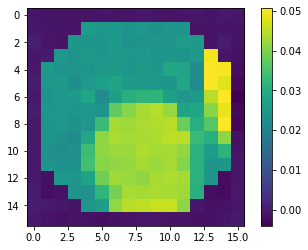

In [23]:
# SIX LAYER RESULTS
############################################################################

model_6L = FNO2d_6L(modes, modes, width).cuda()
print(count_params(model_6L))
output_6L = train_model(model_6L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_6L_model = output_6L.get("model")
torch.save(output_6L_model, 'fno2d_6l.h5')


results_6L = model_metrics(output_6L_model,test_loader,ntrain)

# SIX LAYER RESULTS
############################################################################
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

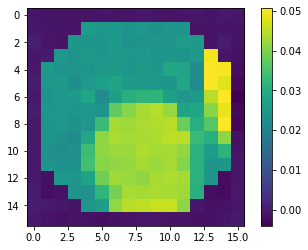

In [32]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_6lv2.png'
plt.savefig('./images/' + save_recon)

3319044
0 19.240684400079772 0.18398479649424554 0.16249239951372146
1 18.64479479996953 0.1171138851866126 0.10701238039135932
2 18.52794330008328 0.10778585117310285 0.10741129633784294
3 18.59807780000847 0.10257182750850916 0.10210089674592018
4 19.444980500033125 0.09943931718170643 0.10568370291590691
5 19.262601600028574 0.09646184297651053 0.10115936678647995
6 18.16440569993574 0.09306026768684388 0.09266208392381668
7 17.986484799999744 0.08928042861074209 0.08962332242727279
8 18.013392199994996 0.08708407996594905 0.08756852117180824
9 17.94495180004742 0.0845836722701788 0.0829616917669773
10 17.953629699884914 0.08261946355551482 0.07960188868641853
11 17.95136139995884 0.0801137866973877 0.07928015002608299
12 18.02285579999443 0.0788593833707273 0.0803406697511673
13 18.086372600053437 0.07727927486598492 0.07665965902805329
14 18.020965999923646 0.07467080505937337 0.07517400225996972
15 18.000838099978864 0.07401480348408222 0.07517337185144425
16 17.976913399994373 0

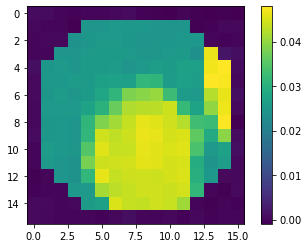

In [24]:
# EIGHT LAYER RESULTS
############################################################################

model_8L = FNO2d_8L(modes, modes, width).cuda()
print(count_params(model_8L))
output_8L = train_model(model_8L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_8L_model = output_8L.get("model")
torch.save(output_8L_model, 'fno2d_8l.h5')


results_8L = model_metrics(output_8L_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

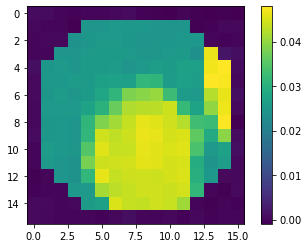

In [33]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_8lv2.png'
#plt.savefig('./images/' + save_recon)

In [39]:
np.mean(results_8L.get('ssim')), np.std(results_8L.get('ssim'))

(0.9399998560329061, 0.026768640714467544)


1 Layer
1663874
TOTAL TIME: ---104.38236680000045
RMSE: ---0.003333161725894805---0.0014171824567482318
PSNR: ---24.067089899473018---2.413291335653067
SSIM: ---0.8197815650537099---0.04497284891212154
UQI: ---0.9915629132112711---0.005649804945150558


2 Layers
1663874
TOTAL TIME: ---143.48116810000647
RMSE: ---0.0027410914288945065---0.0011752522343180846
PSNR: ---25.95367455584884---2.5063768173878174
SSIM: ---0.8848788476675741---0.029903798962027727
UQI: ---0.9943801326523857---0.003707518941374275

4 Layers
1663874
TOTAL TIME: ---227.48713970000608
RMSE: ---0.002347279514966445---0.0011405515295433307
PSNR: ---27.147017014638685---3.243962829021885
SSIM: ---0.9145873484188117---0.031239407287163026
UQI: ---0.9958147433170024---0.0033591851001756


6 Layers
2491394
TOTAL TIME: ---307.26531749999776
RMSE: ---0.002281007437099186---0.0011749824330908503
PSNR: ---27.458660881427257---3.5743994881985213
SSIM: ---0.9198570618445581---0.03522675931308244
UQI: ---0.9958861323842791---0.003541185767768024


8 Layers
3318914
TOTAL TIME: ---395.32088559999465
RMSE: ---0.0022373626727182337---0.001182591818362234
PSNR: ---27.794198608356076---3.699650379845133
SSIM: ---0.9288647265634355---0.03427569857412951
UQI: ---0.996174387737361---0.0033645843224606




<function matplotlib.pyplot.show(close=None, block=None)>

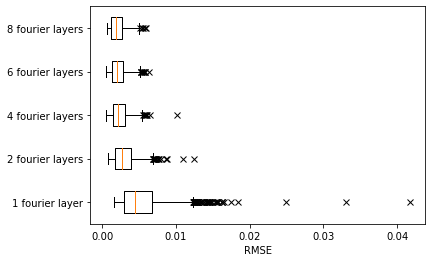

In [40]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("rms"), results_2L.get("rms"), results_4L.get("rms"), results_6L.get("rms"), results_8L.get("rms"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('RMSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

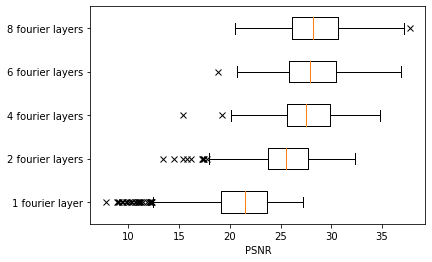

In [41]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("psnr"), results_2L.get("psnr"), results_4L.get("psnr"), results_6L.get("psnr"), results_8L.get("psnr"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('PSNR')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

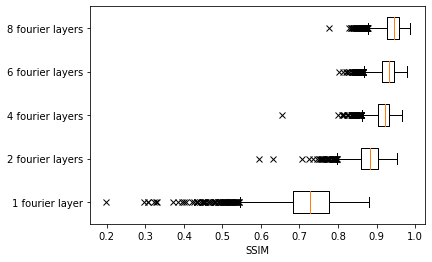

In [42]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("ssim"), results_2L.get("ssim"), results_4L.get("ssim"), results_6L.get("ssim"), results_8L.get("ssim"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('SSIM')
plt.show

# Loading in Models

In [ ]:
# loading our chosen model 

model = torch.load( './models/fno2d_8l.h5')

In [ ]:
# printing out he results of our saved model
results = model_metrics(model,test_loader,ntrain)

In [ ]:
metric_name = 'ssim'        # rms, psnr, ssim

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_name))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_name)
plt.show

In [ ]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)

In [ ]:
print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])

In [ ]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])



In [ ]:
print(outlier_list)

In [ ]:
test_num = 76
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [ ]:
# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

# Dealing with Panda's Data Frames

In [ ]:
import pandas as pd

In [ ]:
df_fno1d = pd.read_pickle('ssim_fno1')

In [ ]:
df_fno2d = pd.DataFrame(outlier_list, columns =['Image_No', 'ssim_score' ])

In [ ]:
df1_len = df_fno1d.shape[0]

comparison = []
for i in range(df1_len):
    if df_fno1d.loc[:,'Image_No'][i] in df_fno2d['Image_No'].unique():
        temp1 = df_fno2d.loc[:,'Image_No'][i]
        temp2 = df_fno2d.loc[:,'ssim_score'][i]
        temp3 = df_fno1d.loc[:,'ssim_score'][i]
        comparison.append([temp1,temp2,temp3])




In [ ]:
len(comparison)

In [ ]:
comparison